In [20]:
from rubin_sim.maf.metrics import CountMetric
from rubin_sim.maf.slicers import HealpixSlicer
from rubin_sim.maf.metric_bundles import MetricBundle, MetricBundleGroup
import rubin_sim.maf.metric_bundles as metric_bundles

from rubin_sim.maf.metrics import BaseMetric
from rubin_sim.maf.slicers import UserPointsSlicer
#from rubin_sim.utils import uniformSphere
#from rubin_sim.data import get_data_dir
from rubin_scheduler.data import get_data_dir #local
from rubin_sim.phot_utils import DustValues

from rubin_sim.maf.utils import m52snr
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import Galactic, ICRS as ICRSFrame
from rubin_sim.maf import db
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery
#from rubin_sim.phot_utils import SFDMap
import astropy.units as u
import healpy as hp
from astropy.cosmology import z_at_value
from collections import OrderedDict

import numpy as np
import glob
import os

import pickle 

In [24]:

# --------------------------------------------
# Power-law GRB afterglow model based on Zeh et al. (2005)
# --------------------------------------------
class GRBAfterglowLC:
    """
    Simulate GRB afterglow light curves using a power-law model.

    Light curves follow:
        m(t) = m_0 + 2.5 * alpha * log10(t/t_0)
    where alpha is the temporal slope (rise or decay), t is time (days),
    and m_0 is the peak magnitude (from Zeh et al. 2005).

    The rise slope is negative (brightening), and the decay is positive (fading).
    """
    def __init__(self, num_samples=100, num_lightcurves=1000, load_from=None):
        """
        Parameters
        ----------
        num_samples : int
            Number of time points to sample in the light curve (log-uniformly spaced).
        load_from : str or None
            If provided and valid, loads light curve templates from a pickle file.
        """
        if load_from and os.path.exists(load_from):
            with open(load_from, 'rb') as f:
                data = pickle.load(f)
            self.data = data['lightcurves']
            self.filts = list(self.data[0].keys())
            print(f"Loaded GRB afterglow templates from {load_from}")
            return

        self.data = []
        self.filts = ["u", "g", "r", "i", "z", "y"]
        self.t_grid = np.logspace(-1, 2, num_samples)  # 0.1 to 100 days

        decay_slope_range = (0.5, 2.5)
        rise_slope_range = (-1.5, -0.5)
        peak_mag_range = (-24, -22)

        rng = np.random.default_rng(42)
        for _ in range(num_lightcurves):
            lc = {}
            for f in self.filts:
                m0 = rng.uniform(*peak_mag_range)
                alpha_rise = rng.uniform(*rise_slope_range)
                alpha_fade = rng.uniform(*decay_slope_range)
                t0 = 0.3
                mag = np.where(
                    self.t_grid < t0,
                    m0 + 2.5 * alpha_rise * np.log10(self.t_grid / t0),
                    m0 + 2.5 * alpha_fade * np.log10(self.t_grid / t0)
                )
                lc[f] = {'ph': self.t_grid, 'mag': mag}
            self.data.append(lc)

    def interp(self, t, filtername, lc_indx=0):
        """
        Interpolate the light curve for the given filter and index at times `t`.

        Parameters
        ----------
        t : array_like
            Times relative to peak (days).
        filtername : str
            LSST filter name (u, g, r, i, z, y).
        lc_indx : int
            Index of the light curve in the template set.

        Returns
        -------
        magnitudes : array_like
            Interpolated magnitudes, clipped at 99 for out-of-range.
        """
        if lc_indx >= len(self.data):
            print(f"Warning: lc_indx {lc_indx} out of bounds, using last template.")
            lc_indx = len(self.data) - 1
        return np.interp(t,
                         self.data[lc_indx][filtername]['ph'],
                         self.data[lc_indx][filtername]['mag'],
                         left=99, right=99)

# --------------------------------------------------
# Light Curve Template Generator (Separate from Population)
# --------------------------------------------------
def generateGRBAfterglowTemplates(
    num_samples=100, num_lightcurves=1000,
    save_to="GRBAfterglow_templates.pkl"
):
    """
    Generate synthetic GRB afterglow light curve templates and save to file.
    """
    if os.path.exists(save_to):
        print(f"Found existing GRB afterglow templates at {save_to}. Not regenerating.")
        return

    lc_model = GRBAfterglowLC(num_samples=num_samples, num_lightcurves=num_lightcurves, load_from=None)
    with open(save_to, "wb") as f:
        pickle.dump({'lightcurves': lc_model.data}, f)
    print(f"Saved synthetic GRB light curve templates to {save_to}")

# --------------------------------------------
# Base GRB Metric with extinction and SNR
# --------------------------------------------
class BaseGRBAfterglowMetric(BaseMetric):
    def __init__(self, metricName='BaseGRBAfterglowMetric',
                 mjdCol='observationStartMJD', m5Col='fiveSigmaDepth',
                 filterCol='filter', nightCol='night',
                 mjd0=59853.5, outputLc=False, badval=-666,
                 filter_include=None,
                 load_from="GRBAfterglow_templates.pkl",
                 lc_model=None,  # <-- NEW
                 **kwargs):
        """
        Parameters
        ----------
        lc_model : GRBAfterglowLC or None
            Shared GRB light curve model object. If None, load from file.
        """
        if lc_model is not None:
            self.lc_model = lc_model
        else:
            self.lc_model = GRBAfterglowLC(load_from=load_from)

        self.ax1 = DustValues().ax1  # From rubin_sim.phot_utils
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.nightCol = nightCol
        self.mjd0 = mjd0
        self.outputLc = outputLc
        self.filter_include = filter_include

        cols = [mjdCol, m5Col, filterCol, nightCol]
        super().__init__(col=cols, metric_name=metricName,
                         units='Detection Efficiency',
                         badval=badval, **kwargs)


    def evaluate_grb(self, dataSlice, slice_point, return_full_obs=True):
        """
        Evaluate GRB light curve at the location and time of the slice point.
        Apply extinction, distance modulus, and optional filter inclusion.
        """
        t = dataSlice[self.mjdCol] - self.mjd0 - slice_point['peak_time']
        mags = np.zeros(t.size)
    
        for f in np.unique(dataSlice[self.filterCol]):
            infilt = np.where(dataSlice[self.filterCol] == f)
            mags[infilt] = self.lc_model.interp(t[infilt], f, slice_point['file_indx'])
            mags[infilt] += self.ax1[f] * slice_point['ebv']
            mags[infilt] += 5 * np.log10(slice_point['distance'] * 1e6) - 5
    
        snr = m52snr(mags, dataSlice[self.m5Col])
        filters = dataSlice[self.filterCol]
        times = t
    
        if return_full_obs:
            obs_record = {
                'mjd_obs': dataSlice[self.mjdCol],
                'mag_obs': mags,
                'snr_obs': snr,
                'filter': filters,
                # NO 'detected' YET -- will be set later if detected!
            }
            return snr, filters, times, obs_record
        return snr, filters, times

# --------------------------------------------
# Unified Detection metric
# --------------------------------------------
class GRBAfterglowDetectMetric(BaseGRBAfterglowMetric):
    """ 

    Option A: ≥2 detections in a single filter, ≥30 minutes apart
    
    Option B: ≥2 epochs, second has ≥2 filters; first can be a non-detection
    
    This is an “either/or” detection logic. 
    
    This event is detected if it passes either the intra-night multi-detection or the epoch-based detection criteria.
    
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.metricName = kwargs.get('metricName', 'GRB_Detect')
        self.obs_records = {}  # <-- NEW: to store all detected event records individually

    def run(self, dataSlice, slice_point=None):
        snr, filters, times, obs_record = self.evaluate_grb(dataSlice, slice_point, return_full_obs=True)
        
        if self.filter_include is not None:
            keep = np.isin(filters, self.filter_include)
            snr = snr[keep]
            filters = filters[keep]
            times = times[keep]
            for k in ['mjd_obs', 'mag_obs']:
                obs_record[k] = obs_record[k][keep]

        # -------- Detection Logic --------
        
        detected = False
    
        # Option A: 2 detections in same filter ≥30min apart
        for f in np.unique(filters):
            mask = filters == f
            if np.sum(snr[mask] >= 5) >= 2:
                if np.ptp(times[mask]) >= 0.5 / 24:
                    detected = True
                    break
    
        # Option B: 2 filters ≥5σ ≥30min apart
        if not detected:
            t_detect = times[snr >= 5]
            if len(t_detect) > 0:
                if len(np.unique(filters[snr >= 5])) >= 2:
                    if np.ptp(t_detect) >= 0.5 / 24:
                        detected = True

        # -------- Save Detection Metadata --------
    
        if detected:
            detected_mask = snr >= 5
            obs_record['detected'] = (snr >= 5)
            self.latest_obs_record = obs_record

            # Calculate rise and fade times
            first_det_mjd = np.nan
            last_det_mjd = np.nan
            rise_time = np.nan
            fade_time = np.nan
        
            if np.any(detected_mask):
                first_det_mjd = obs_record['mjd_obs'][detected_mask].min()
                last_det_mjd = obs_record['mjd_obs'][detected_mask].max()
                rise_time = first_det_mjd - (self.mjd0 + slice_point['peak_time'])
                fade_time = last_det_mjd - (self.mjd0 + slice_point['peak_time'])
        
            peak_index = np.argmin(obs_record['mag_obs'])
            peak_mjd = obs_record['mjd_obs'][peak_index]
            peak_mag = obs_record['mag_obs'][peak_index]
        
            # Update obs_record with full metadata
            obs_record.update({
                'first_det_mjd': first_det_mjd,
                'last_det_mjd': last_det_mjd,
                'rise_time_days': rise_time,
                'fade_time_days': fade_time,
                'sid': slice_point['sid'],
                'file_indx': slice_point['file_indx'],
                'ra': slice_point['ra'],
                'dec': slice_point['dec'],
                'distance_Mpc': slice_point['distance'],
                'peak_mjd': peak_mjd,
                'peak_mag': peak_mag,
                'ebv': slice_point['ebv'],
            })
        
            # Save this full event
            self.obs_records[slice_point['sid']] = obs_record
        
            self.latest_obs_record = obs_record
            return 1.0
        else:
            self.latest_obs_record = None
            return 0.0


# --------------------------------------------
# GRB volumetric rate model (on-axis ≈ 10⁻⁹ Mpc⁻³ yr⁻¹)
# --------------------------------------------
def sample_grb_rate_from_volume(t_start, t_end, d_min, d_max, rate_density=1e-8): #1e-8 to account for dirty fireball and off axis, 1e-9 without
    """
    Estimate the number of GRBs from comoving volume and volumetric rate.

    Parameters
    ----------
    t_start : float
        Start of the time window (days).
    t_end : float
        End of the time window (days).
    d_min : float
        Minimum luminosity distance in Mpc.
    d_max : float
        Maximum luminosity distance in Mpc.
    rate_density : float
        Volumetric GRB rate in events/Mpc^3/yr.

    Returns
    -------
    int
        Expected number of GRBs in the survey.
    """
    years = (t_end - t_start) / 365.25
    z_min = z_at_value(cosmo.comoving_distance, d_min * u.Mpc)
    z_max = z_at_value(cosmo.comoving_distance, d_max * u.Mpc)

    V = cosmo.comoving_volume(z_max).to(u.Mpc**3).value - cosmo.comoving_volume(z_min).to(u.Mpc**3).value
    return np.random.poisson(rate_density * V * years)
    

def generateGRBPopSlicer(t_start=1, t_end=3652, seed=42,
                         d_min=10, d_max=1000, num_lightcurves=1000,
                         gal_lat_cut=None, rate_density=1e-8,
                         opsdb=None, load_from=None, save_to=None):
    """
    Inject GRBs using LSST footprint-weighted sky sampling.
    """
    if load_from and os.path.exists(load_from):
        with open(load_from, 'rb') as f:
            slice_data = pickle.load(f)
        slicer = UserPointsSlicer(ra=slice_data['ra'], dec=slice_data['dec'], badval=0)
        slicer.slice_points.update(slice_data)
        print(f"Loaded GRB population from {load_from}")
        return slicer

    rng = np.random.default_rng(seed)
    n_events = sample_grb_rate_from_volume(t_start, t_end, d_min, d_max, rate_density=rate_density)
    print(f"Simulated {n_events} GRB events using rate_density = {rate_density:.1e}")

    # --- Generate LSST-like sky map ---
    slicer_map = HealpixSlicer(nside=64)
    metric = CountMetric(col='night')
    bundle = MetricBundle(metric, slicer_map, '')
    group = MetricBundleGroup({'sky': bundle}, opsdb, out_dir='temp_out')
    group.run_all()

    raw_map = bundle.metric_values
    prob_map = np.where(np.isfinite(raw_map) & (raw_map > 0), raw_map, 0)
    
    total = np.sum(prob_map)
    if total == 0:
        raise ValueError("The probability map is empty after filtering.")
    prob_map /= total
    
    exposure_map = np.nan_to_num(bundle.metric_values)

    total = np.sum(prob_map)
    
    if total == 0:
        raise ValueError("The probability map is empty after masking negatives.")
    
    prob_map /= total  # Normalize
    print(f"[INFO] LSST sky footprint map normalized")

    # --- Sample pixel indices from probability map ---
    npix = len(prob_map)
    sampled_pix = rng.choice(np.arange(npix), size=n_events, p=prob_map)
    theta, phi = hp.pix2ang(slicer_map.nside, sampled_pix, nest=False)
    dec = 0.5 * np.pi - theta
    ra = phi
    ra = np.mod(ra, 2 * np.pi)  # Wrap RA into [0, 2π] radians


    dec = np.clip(dec, -np.pi/2 + 1e-5, np.pi/2 - 1e-5)
    ra_deg = np.degrees(ra)
    dec_deg = np.degrees(dec)
    print(f"[CHECK] Injected Dec range [deg]: {dec_deg.min():.2f} to {dec_deg.max():.2f}")

    slicer = UserPointsSlicer(ra=ra, dec=dec, badval=0)

    distances = rng.uniform(d_min, d_max, n_events)
    peak_times = rng.uniform(t_start, t_end, n_events)
    file_indx = rng.integers(0, num_lightcurves, n_events)

    coords = SkyCoord(ra=ra_deg * u.deg, dec=dec_deg * u.deg, frame='icrs')
    sfd = SFDQuery()
    ebv_vals = sfd(coords)

    if gal_lat_cut is not None:
        b = coords.galactic.b.deg
        mask = np.abs(b) > gal_lat_cut
        ra, dec = ra[mask], dec[mask]
        distances = distances[mask]
        peak_times = peak_times[mask]
        file_indx = file_indx[mask]
        ebv_vals = ebv_vals[mask]
        coords = coords[mask]

    slicer.slice_points['distance'] = distances
    slicer.slice_points['peak_time'] = peak_times
    slicer.slice_points['file_indx'] = file_indx
    slicer.slice_points['ebv'] = ebv_vals
    slicer.slice_points['gall'] = coords.galactic.l.deg
    slicer.slice_points['galb'] = coords.galactic.b.deg

    if save_to:
        with open(save_to, 'wb') as f:
            pickle.dump(dict(slicer.slice_points), f)
        print(f"Saved GRB population to {save_to}")

    return slicer


Loaded GRB afterglow templates from GRB_KNe_Attempt_templates.pkl
Simulated 42053 GRB events using rate_density = 1.0e-06
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
[INFO] LSST sky footprint map normalized
[CHECK] Injected Dec range [deg]: -89.27 to 34.95
Saved GRB population to GRB_KNe_Attempt_F/rd1em06/GRB_KNe_Attempt_rd1em06.pkl

--- Running four_roll_v4.3.1_10yrs ---
Out of 42053 simulated GRB_KNe events, Rubin detected 19095 under the four_roll_v4.3.1_10yrs cadence.
Of those, each event was observed in an average of 2.7 ± 1.5 filters.


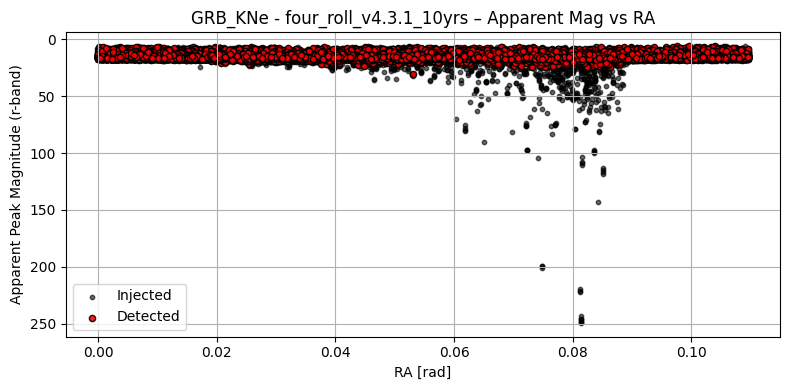

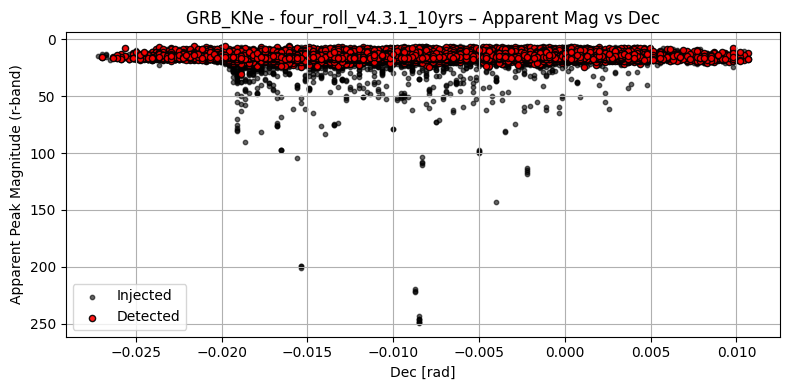

[DEBUG] RA range [rad]: 0.00 – 0.11
[DEBUG] Dec range [rad]: -0.03 – 0.01
[DEBUG] Dec range [deg]: -1.56 – 0.61
[DEBUG] Detected RA, Dec: 3.13, -0.87
[DEBUG] Detected RA, Dec: 6.03, -0.96
[DEBUG] Detected RA, Dec: 5.95, -0.50
[DEBUG] Detected RA, Dec: 6.05, -0.13
[DEBUG] Detected RA, Dec: 0.90, -0.48
[DEBUG] Detected RA, Dec: 3.71, -0.80
[DEBUG] Detected RA, Dec: 3.62, 0.04
[DEBUG] Detected RA, Dec: 3.26, -1.13
[DEBUG] Detected RA, Dec: 4.57, 0.07
[DEBUG] Detected RA, Dec: 3.73, -0.09
[DEBUG] Detected RA, Dec: 1.25, -0.51
[DEBUG] Detected RA, Dec: 1.14, -0.65
[DEBUG] Detected RA, Dec: 3.34, -0.58
[DEBUG] Detected RA, Dec: 5.98, -1.00
[DEBUG] Detected RA, Dec: 3.94, 0.04
[DEBUG] Detected RA, Dec: 5.95, -0.74
[DEBUG] Detected RA, Dec: 1.18, 0.05
[DEBUG] Detected RA, Dec: 6.06, -0.37
[DEBUG] Detected RA, Dec: 3.62, 0.06
[DEBUG] Detected RA, Dec: 4.57, -0.91
[DEBUG] Detected RA, Dec: 2.58, -0.24
[DEBUG] Detected RA, Dec: 5.55, -1.03
[DEBUG] Detected RA, Dec: 2.64, -1.39
[DEBUG] Detected RA

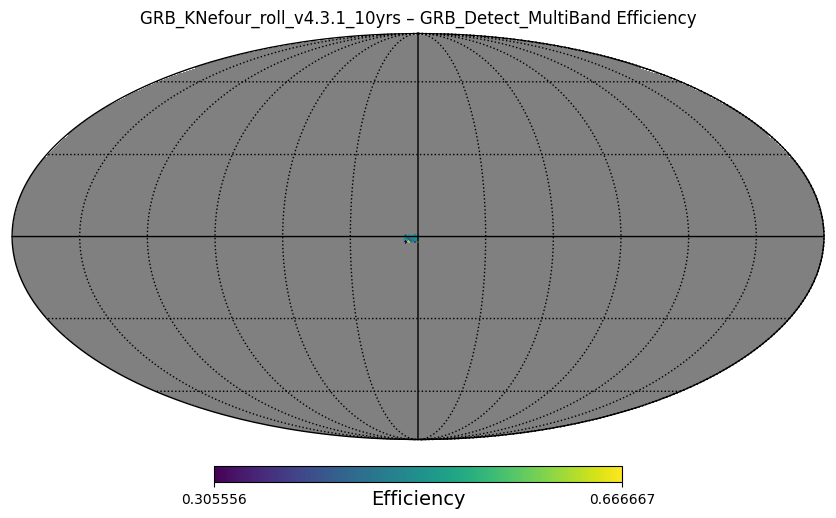

Loaded GRB population from GRB_KNe_Attempt_F/rd1em06/GRB_KNe_Attempt_rd1em06.pkl

--- Running baseline_v4.3.1_10yrs ---
Out of 42053 simulated GRB_KNe events, Rubin detected 19578 under the baseline_v4.3.1_10yrs cadence.
Of those, each event was observed in an average of 2.8 ± 1.5 filters.


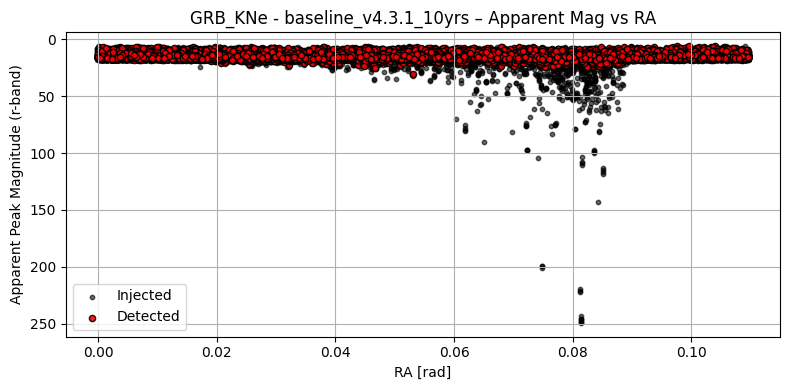

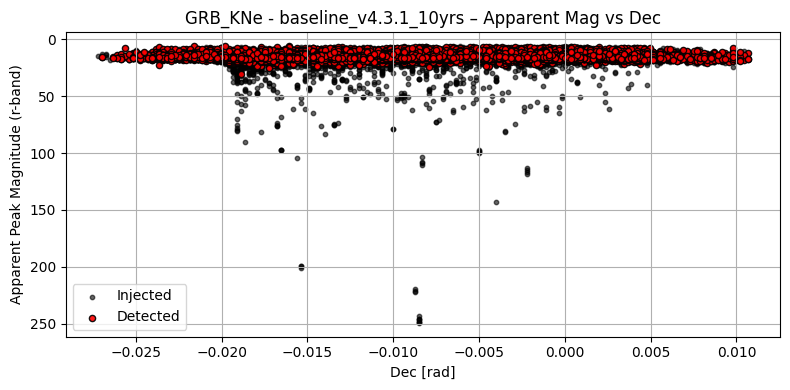

[DEBUG] RA range [rad]: 0.00 – 0.11
[DEBUG] Dec range [rad]: -0.03 – 0.01
[DEBUG] Dec range [deg]: -1.56 – 0.61
[DEBUG] Detected RA, Dec: 3.34, 0.11
[DEBUG] Detected RA, Dec: 0.10, -0.66
[DEBUG] Detected RA, Dec: 4.81, -0.80
[DEBUG] Detected RA, Dec: 3.08, -0.30
[DEBUG] Detected RA, Dec: 1.11, -0.88
[DEBUG] Detected RA, Dec: 2.63, 0.03
[DEBUG] Detected RA, Dec: 1.75, -0.57
[DEBUG] Detected RA, Dec: 3.13, -0.27
[DEBUG] Detected RA, Dec: 4.84, -0.42
[DEBUG] Detected RA, Dec: 3.19, -0.44
[DEBUG] Detected RA, Dec: 5.58, -0.98
[DEBUG] Detected RA, Dec: 4.98, -0.76
[DEBUG] Detected RA, Dec: 4.17, -0.24
[DEBUG] Detected RA, Dec: 3.87, -0.45
[DEBUG] Detected RA, Dec: 5.13, -0.76
[DEBUG] Detected RA, Dec: 1.61, -0.27


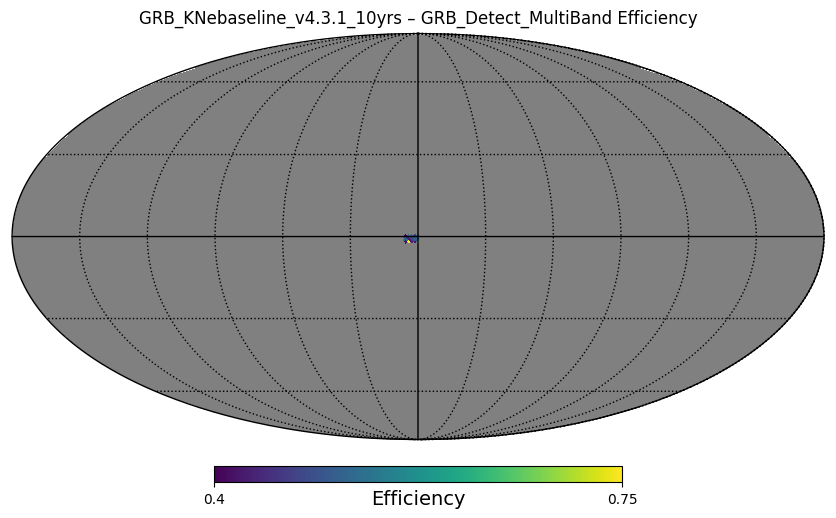

In [25]:
# ---- ALL 10 years Configuration ----
cadences = ['four_roll_v4.3.1_10yrs', 'baseline_v4.3.1_10yrs']
rate_density = 1e-6
rate_str = f"rd{rate_density:.0e}".replace("-", "m")  # Example: 1e-8 to rd1e-8
filters = ['u', 'g', 'r', 'i', 'z', 'y']
grbs_dir = f"GRB_KNe_Attempt_F/{rate_str}"
grb_templates_file = "GRB_KNe_Attempt_templates.pkl"
grb_pop_file = os.path.join(grbs_dir, f"GRB_KNe_Attempt_{rate_str}.pkl")
t_start = 1
t_end = 3652
dmin, dmax = 10, 1000
gal_lat_cut = None
os.makedirs(grbs_dir, exist_ok=True)

# Will hold slicers per cadence
slicers = {}

if not os.path.exists(grb_templates_file):
    from local_GRBafterglows_metric import generateGRBAfterglowTemplates
    generateGRBAfterglowTemplates(save_to=grb_templates_file)
shared_lc_model = GRBAfterglowLC(load_from=grb_templates_file)

for cadence in cadences:
    runName = cadence
    db_dir = "/Users/andradenebula/Documents/Research/Transient_Metrics/Multi_Transient_Metrics_Hub"
    db_path = os.path.join(db_dir, f"{cadence}.db")
    opsdb = db_path
    outDir = os.path.join(grbs_dir, f"Metric_temp_{cadence}")
    os.makedirs(outDir, exist_ok=True)
    resultsDb = db.ResultsDb(out_dir=outDir)

    # Load or generate population with correct footprint
    if not os.path.exists(grb_pop_file):
        slicer = generateGRBPopSlicer(
            t_start=t_start, t_end=t_end, seed=42,
            d_min=dmin, d_max=dmax, num_lightcurves=1000,
            gal_lat_cut=gal_lat_cut, rate_density=rate_density,
            save_to=grb_pop_file, opsdb=opsdb
        )
    else:
        slicer = generateGRBPopSlicer(load_from=grb_pop_file)

    slicers[cadence] = slicer
    n_events = len(slicer.slice_points['distance'])

#=========================================================
    print(f"\n--- Running {cadence} ---")
    per_filter_metrics = OrderedDict()
    for filt in filters:
        detect = GRBAfterglowDetectMetric(metricName=f"GRB_KNe_Detect_{filt}", filter_include=[filt], lc_model=shared_lc_model)
        per_filter_metrics[f"GRB_KNe_Detect_{filt}"] = metric_bundles.MetricBundle(detect, slicer, '')

    pf_group = metric_bundles.MetricBundleGroup(per_filter_metrics, opsdb, out_dir=outDir, results_db=resultsDb)
    pf_group.run_all()

    n_filters_detected_per_event = np.array([
        sum(per_filter_metrics[f"GRB_KNe_Detect_{f}"].metric_values[i] == 1 
            and not per_filter_metrics[f"GRB_KNe_Detect_{f}"].metric_values.mask[i]
            for f in filters)
        for i in range(n_events)
    ])
    detected_mask = n_filters_detected_per_event >= 1
    n_detected = np.sum(detected_mask)
    mean_filters = np.mean(n_filters_detected_per_event[detected_mask])
    std_filters = np.std(n_filters_detected_per_event[detected_mask])

    print(f"Out of {n_events} simulated GRB_KNe events, Rubin detected {n_detected} under the {cadence} cadence.")
    print(f"Of those, each event was observed in an average of {mean_filters:.1f} ± {std_filters:.1f} filters.")


    # Plot: Apparent magnitude vs RA and Dec for one filter (e.g. 'r')
    filtername = 'r'
    ax1 = DustValues().ax1
    
    ras, decs, peak_mags, detected_flags = [], [], [], []
    
    for i in range(n_events):
        ra = slicer.slice_points['ra'][i]
        dec = slicer.slice_points['dec'][i]  # this is in radians already
        d = slicer.slice_points['distance'][i]
        ebv = slicer.slice_points['ebv'][i]
        file_indx = slicer.slice_points['file_indx'][i]
        
        m_peak = np.min(shared_lc_model.data[file_indx][filtername]['mag'])
        A = ax1[filtername] * ebv
        dm = 5 * np.log10(d * 1e6) - 5
        m_app = m_peak + dm + A
    
        ras.append(ra)
        decs.append(dec)
        peak_mags.append(m_app)
    
        detected = any(
            per_filter_metrics[f"GRB_KNe_Detect_{f}"].metric_values[i] == 1
            and not per_filter_metrics[f"GRB_KNe_Detect_{f}"].metric_values.mask[i]
            for f in filters
        )
        detected_flags.append(detected)

    # Plot: Apparent magnitude vs RA
    
    plt.figure(figsize=(8, 4))
    plt.scatter(ras, peak_mags, c='black', s=10, label='Injected', alpha=0.6)
    plt.scatter(np.array(ras)[detected_flags], np.array(peak_mags)[detected_flags],
                c='red', s=20, label='Detected', alpha=0.9, edgecolors='black')
    plt.xlabel("RA [rad]")
    plt.ylabel(f"Apparent Peak Magnitude ({filtername}-band)")
    plt.title(f"GRB_KNe - {cadence} – Apparent Mag vs RA")
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot: Apparent magnitude vs Dec
    plt.figure(figsize=(8, 4))
    plt.scatter(decs, peak_mags, c='black', s=10, label='Injected', alpha=0.6)
    plt.scatter(np.array(decs)[detected_flags], np.array(peak_mags)[detected_flags],
                c='red', s=20, label='Detected', alpha=0.9, edgecolors='black')
    plt.xlabel("Dec [rad]")
    plt.ylabel(f"Apparent Peak Magnitude ({filtername}-band)")
    plt.title(f"GRB_KNe - {cadence} – Apparent Mag vs Dec")
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


    # Optional: save summaries or plot
    outfile = os.path.join(grbs_dir, f"local_efficiency_{cadence}_KNeGRB_KNe.csv")
    with open(outfile, "w") as out:
        out.write("sid,n_filters_detected\n")
        for i in range(n_events):
            out.write(f"{i},{n_filters_detected_per_event[i]}\n")

    # Add multi-band metrics
    multi_metrics = [
        GRBAfterglowDetectMetric(metricName="GRB_Detect_MultiBand", lc_model=shared_lc_model),
        #GRBAfterglowCharacterizeMetric(metricName="GRB_Characterize_MultiBand", lc_model=shared_lc_model),
        #GRBAfterglowSpecTriggerableMetric(metricName="GRB_SpecTriggerable_MultiBand", lc_model=shared_lc_model),
        #GRBAfterglowColorEvolveMetric(metricName="GRB_ColorEvolve_MultiBand", lc_model=shared_lc_model),
        #GRBAfterglowHistoricalMatchMetric(metricName="GRB_HistoricalMatch_MultiBand", lc_model=shared_lc_model)
    ]

    for metric in multi_metrics:
        mb_key = f"{runName}_{metric.__class__.__name__}"
        bundle = metric_bundles.MetricBundle(metric, slicer, '', file_root=mb_key, plot_funcs=[], summary_metrics=[])
        bgroup = metric_bundles.MetricBundleGroup({mb_key: bundle}, opsdb, out_dir=outDir, results_db=resultsDb)
        bgroup.run_all()

        # Healpix plotting

        ra_rad = slicer.slice_points['ra']
        dec_rad = slicer.slice_points['dec']


        print(f"[DEBUG] RA range [rad]: {ra_rad.min():.2f} – {ra_rad.max():.2f}")
        print(f"[DEBUG] Dec range [rad]: {dec_rad.min():.2f} – {dec_rad.max():.2f}")
        print(f"[DEBUG] Dec range [deg]: {np.degrees(dec_rad).min():.2f} – {np.degrees(dec_rad).max():.2f}")
        
        nside = slicer.nside if hasattr(slicer, 'nside') else 64
        npix = hp.nside2npix(nside)
        injected_map = np.zeros(npix)
        detected_map = np.zeros(npix)

        ra_rad = slicer.slice_points['ra']
        dec_rad = slicer.slice_points['dec']
        theta = 0.5 * np.pi - dec_rad
        phi = ra_rad
        pix_inds = hp.ang2pix(nside, theta, phi)

        for i, pix in enumerate(pix_inds):
            injected_map[pix] += 1
            if bundle.metric_values[i] == 1:
                if np.random.rand() < 0.001:
                    print(f"[DEBUG] Detected RA, Dec: {np.degrees(ra_rad[i]):.2f}, {np.degrees(dec_rad[i]):.2f}")
                detected_map[pix] += 1

        eff_map = np.zeros(npix)
        mask = injected_map > 0
        eff_map[mask] = detected_map[mask] / injected_map[mask]
        eff_map[~mask] = hp.UNSEEN

        hp.mollview(eff_map, title=f"GRB_KNe{runName} – {metric.metricName} Efficiency", unit='Efficiency', cmap='viridis')
        hp.graticule()
        plt.show()


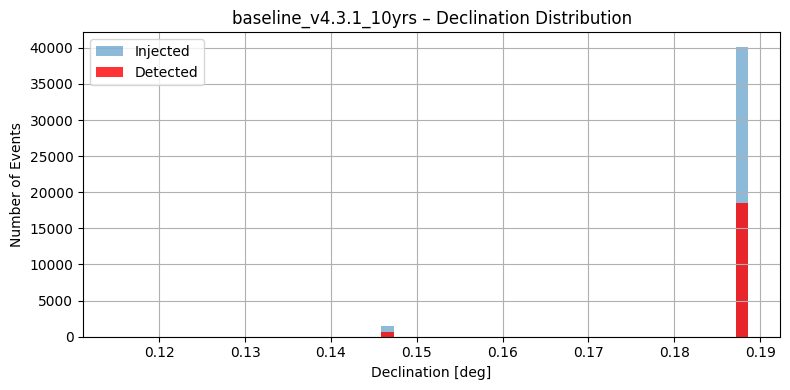

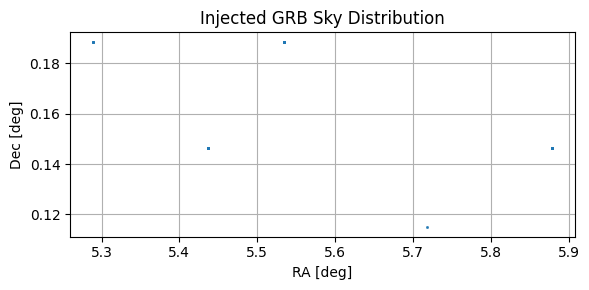

In [23]:
plt.figure(figsize=(8, 4))
plt.hist(np.degrees(slicer.slice_points['dec']), bins=50, alpha=0.5, label='Injected')
plt.hist(np.degrees(np.array(decs)[detected_flags]), bins=50, alpha=0.8, label='Detected', color='red')
plt.xlabel("Declination [deg]")
plt.ylabel("Number of Events")
plt.title(f"{cadence} – Declination Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.scatter(np.degrees(ra_rad), np.degrees(dec_rad), s=1, alpha=0.3)
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.title("Injected GRB Sky Distribution")
plt.grid(True)
plt.tight_layout()
plt.show()
